**Part 1:** Defining transport sections on the plane that cuts vertically at the shelf break.

In [1]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/')
import functions_transport_V

## Key variables:
* gdepv: depth of V-grid points
* vmask: mask for V-grid
* mbathy: fortran (1-based) index of deepest water cell, T-grid
* e1v: 	grid spacing on V-grid in u direction
* e3v
* note: the cross section at the shelf break plane is looking out of the canyon from the inside.

In [2]:
def get_variables_planes(dirname, filename):
    with nc.Dataset(os.path.join(dirname, filename), 'r') as nbl:
        x, y =  slice(1,-1,None), slice(1,-1,None)
        gdepv = nbl.variables['gdepv'][0, :, 1, 1]
        vmask = nbl.variables['vmask'][0, :, y, x]
        mbathy = nbl.variables['mbathy'][0, y, x]
        e1v = nbl.variables['e1v'][0, y, x]
        e3v_0 = nbl.variables['e3v_0'][0, :, y, x]  
        return gdepv, vmask, mbathy, e1v, e3v_0
    
# ------------------------------------------------------------------------------------------------
    
def get_indices_V(gdepv, vmask, mbathy, e1v, e3v_0):
    
    # z index of the shelf platform
    # 1. find where the depth of v point is closest to 80
    # 2. re-assess answer later
    ind_shelf = np.argmin(np.abs(gdepv - 80))

    # y index of shelf break 
    # 1. get top view of vmask at shelf depth
    # 2. extract wet/dry values along x=1 
    # 3. find the first wet cell
    ind_plane = np.where(vmask[ind_shelf, :, 1] == 1)[0][0]

    print('ind_plane', ind_plane)

    # z index of the shelf platform
    cells_shelf = vmask[ind_shelf, ind_plane, :]
    cells_shelf_W = np.count_nonzero(cells_shelf)
    cells_shelf_D = vmask.shape[-1] - cells_shelf_W
    while cells_shelf_D < 4:
        ind_shelf += 1
        cells_shelf = vmask[ind_shelf, ind_plane, :]
        cells_shelf_W = np.count_nonzero(cells_shelf)
        cells_shelf_D = vmask.shape[-1] - cells_shelf_W
    depth_shelf = gdepv[ind_shelf]

    print('ind_shelf', ind_shelf)
    print('depth_shelf', depth_shelf)

    # z index of canyon bottom
    # 1. mbathy gives maximum depth level everywhere
    # 2. this value is given in fortran indexing
    # 3. subtracting 1 gives the deepest level with wet cells
    ind_bottom = (mbathy[ind_plane,:].max())-1
    depth_bottom = gdepv[ind_bottom]

    print('ind_bottom', ind_bottom)
    print('depth_bottom', depth_bottom)

    # x index of canyon axis
    # 1. find all wet cells along canyon bottom
    # 2. find the middle wet cell for symmetric axis
    # 3. this could have a 0.5 so return integer

    ind_axis = int(np.median(np.where(vmask[ind_bottom, ind_plane, :]==1)))
    print('ind_axis', ind_axis)

    # x index of rims
    # 1. last land value on left
    # 2. first land value on right
    ind_rimW0 = np.where(vmask[ind_shelf, ind_plane, :ind_axis]==0)[0][-1]
    ind_rimE0 = np.where(vmask[ind_shelf, ind_plane, ind_axis:]==0)[0][0] + ind_axis
    axis_to_rim = min(ind_rimE0 - ind_axis, ind_axis - ind_rimW0)
    ind_rimW = ind_axis - axis_to_rim
    ind_rimE = ind_axis + axis_to_rim

    print('ind_rimW', ind_rimW)
    print('ind_rimE', ind_rimE)

    # z index of half canyon
    # 1. area of individual wet cells
    cell_x_j = e1v[ind_plane, :]
    cell_y_j = e3v_0[:, ind_plane, :]
    area_j = vmask[:, ind_plane, :] * cell_x_j * cell_y_j

    # 2. total area of every depth level
    area_all = np.zeros(area_j.shape[0])
    for depth_ind in range(area_j.shape[0]):
        area_all[depth_ind] = area_j[depth_ind, :].sum()

    # 3. areas and indices of only the depth levels inside the canyon
    area_canyon = area_all[ind_shelf:ind_bottom]
    area_canyon_inds = np.arange(ind_shelf,ind_bottom)

    # 4. half the area of the canyon
    total_area_canyon = np.sum(area_canyon)
    half_area_canyon = total_area_canyon / 2

    # 5. relative level where cumulative area is closest to the half area
    cumsum_area_canyon = np.cumsum(area_canyon)
    relative_ind_half = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()

    # 6. the real depth level for half area
    ind_half = area_canyon_inds[relative_ind_half]
    depth_half = gdepv[ind_half]

    print('ind_half', ind_half)
    print('depth_half', depth_half)
    
    # x index of shelves
    # 1. try to make shf sections same width as rim sections
    # 2. if 4 cells away from edge, bring closer to centre
    # 3. find smallest distance from centre and use as width
    ind_shfW0 = ind_rimW - axis_to_rim
    ind_shfE0 = ind_rimE + axis_to_rim
    while ind_shfW0 <= 4:
        ind_shfW0 += 1
    while ind_shfE0 >= vmask.shape[-1]-4:
        ind_shfE0 -= 1
    axis_to_shf = min(ind_shfE0 - ind_axis, ind_axis - ind_shfW0)
    ind_shfW = ind_axis - axis_to_shf
    ind_shfE = ind_axis + axis_to_shf

    print('ind_shfW', ind_shfW)
    print('ind_shfE', ind_shfE)
    
    return ind_plane, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE,\
            depth_shelf, depth_bottom, depth_half, area_j
    
# ------------------------------------------------------------------------------------------------

def extract_sections(variable, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE):
    ''' Extracts the values of a given variable for
    all the sections dividing the plane at the shelf break.
    '''
    var_shfW = variable[..., : ind_shelf, ind_shfW : ind_rimW]
    var_rimW = variable[..., : ind_shelf, ind_rimW : ind_axis]
    var_rimE = variable[..., : ind_shelf, ind_axis : ind_rimE]
    var_shfE = variable[..., : ind_shelf, ind_rimE : ind_shfE]
    
    var_topW = variable[..., ind_shelf : ind_half + 1, ind_rimW : ind_axis]
    var_topE = variable[..., ind_shelf : ind_half + 1, ind_axis : ind_rimE]
    
    var_botW = variable[..., ind_half + 1 : ind_bottom, ind_rimW : ind_axis]
    var_botE = variable[..., ind_half + 1 : ind_bottom, ind_axis : ind_rimE]
    
    return var_shfW, var_rimW, var_rimE, var_shfE, var_topW, var_topE, var_botW, var_botE

# ------------------------------------------------------------------------------------------------

def total_sections(axis, var_shfW, var_rimW, var_rimE, var_shfE, var_topW, var_topE, var_botW, var_botE):
    ''' Finds sum of all values in every section of the shelf break plane.
    '''
    tot_var_shfW = np.sum(var_shfW, axis=axis)
    tot_var_rimW = np.sum(var_rimW, axis=axis)
    tot_var_rimE = np.sum(var_rimE, axis=axis)
    tot_var_shfE = np.sum(var_shfE, axis=axis)

    tot_var_topW = np.sum(var_topW, axis=axis)
    tot_var_topE = np.sum(var_topE, axis=axis)
    tot_var_botW = np.sum(var_botW, axis=axis)
    tot_var_botE = np.sum(var_botE, axis=axis)
    
    return tot_var_shfW, tot_var_rimW, tot_var_rimE, tot_var_shfE, tot_var_topW, tot_var_topE, tot_var_botW, tot_var_botE

In [3]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'

gdepv, vmask, mbathy, e1v, e3v_0 = get_variables_planes(dirname, filename)

gdepv.shape, vmask.shape, mbathy.shape, e1v.shape, e3v_0.shape

((80,), (80, 272, 242), (272, 242), (272, 242), (80, 272, 242))

In [4]:
ind_plane, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE,\
depth_shelf, depth_bottom, depth_half, area_j = functions_transport_V.get_indices_V(gdepv, vmask, mbathy, e1v, e3v_0)

ind_plane 178
ind_shelf 10
depth_shelf 91.875
ind_bottom 60
depth_bottom 534.672
ind_axis 110
ind_rimW 48
ind_rimE 172
ind_half 25
depth_half 223.125
ind_shfW 5
ind_shfE 215


In [5]:
area_j_shfW, area_j_rimW, area_j_rimE, area_j_shfE, area_j_topW, area_j_topE, area_j_botW, area_j_botE = functions_transport_V.extract_sections(
    area_j, ind_shelf, ind_bottom, ind_axis, ind_rimW, ind_rimE, ind_half, ind_shfW, ind_shfE)

In [6]:
area_j_shfW.shape, area_j_botE.shape

((10, 43), (34, 62))

In [7]:
axis = None

tot_area_j_shfW, tot_area_j_rimW, tot_area_j_rimE, tot_area_j_shfE, tot_area_j_topW, tot_area_j_topE, tot_area_j_botW, tot_area_j_botE = functions_transport_V.total_sections(
    axis, area_j_shfW, area_j_rimW, area_j_rimE, area_j_shfE, area_j_topW, area_j_topE, area_j_botW, area_j_botE)

In [8]:
for i in (tot_area_j_shfW, tot_area_j_rimW, tot_area_j_rimE, tot_area_j_shfE, tot_area_j_topW, tot_area_j_topE, tot_area_j_botW, tot_area_j_botE):
    print(i)

2380592.5277
3639164.23756
3639164.33009
2384084.29181
3910240.00033
4004139.11848
3839152.88523
4039977.36966


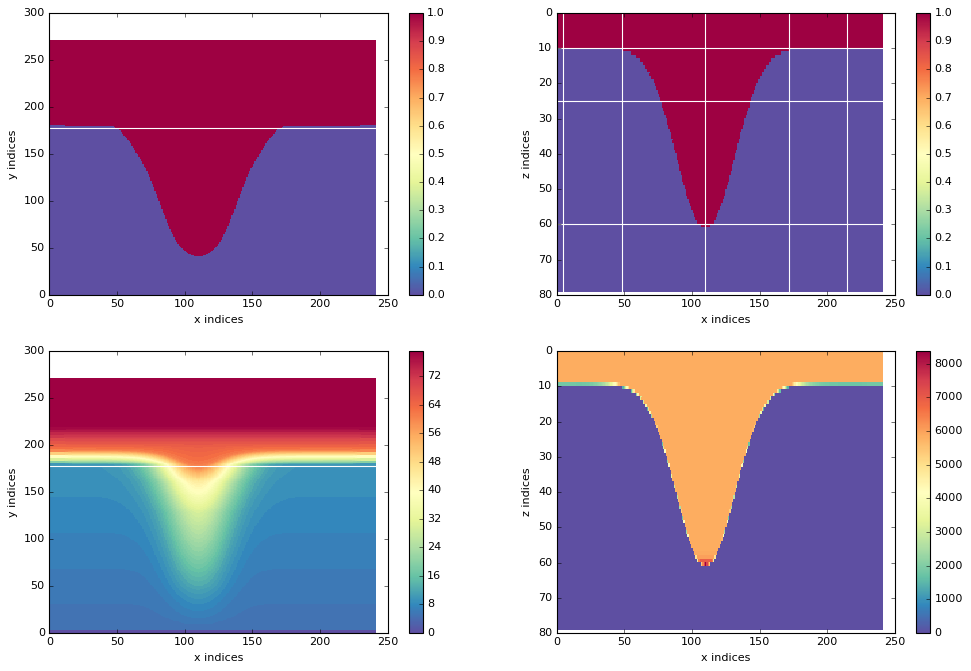

In [9]:
xs = np.arange(vmask.shape[-1])
ys = np.arange(vmask.shape[-2])
zs = np.arange(vmask.shape[-3])

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(15,10))
p1 = ax1.pcolormesh(xs, ys, vmask[ind_shelf, :, :], cmap=cm.Spectral_r)
p2 = ax2.pcolormesh(xs, zs, vmask[:, ind_plane, :], cmap=cm.Spectral_r)
p3 = ax3.pcolormesh(xs, ys, mbathy, cmap=cm.Spectral_r)
p4 = ax4.pcolormesh(xs, zs, area_j, cmap=cm.Spectral_r)
fig.colorbar(p1, ax=ax1)
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)
fig.colorbar(p4, ax=ax4)
ax2.invert_yaxis()
ax4.invert_yaxis()

ax1.axhline(ind_plane, c='white')
ax2.axhline(ind_shelf, c='white')
ax2.axhline(ind_bottom, c='white')
ax2.axvline(ind_axis, c='white')
ax3.axhline(ind_plane, c='white')
ax2.axvline(ind_rimW, c='white')
ax2.axvline(ind_rimE, c='white')
ax2.axhline(ind_half, c='white')
ax2.axvline(ind_shfW, c='white')
ax2.axvline(ind_shfE, c='white')

for ax in [ax1, ax3]:
    ax.set_xlabel('x indices')
    ax.set_ylabel('y indices')
for ax in [ax2, ax4]:
    ax.set_xlabel('x indices')
    ax.set_ylabel('z indices')